# Clustering of movies from a Movielens dataset using k-means and dimensionality reduction

For this homework, we are requested to write a notebook that at least applies the following baselines to perform this task:
1. standard k-means;
2. A Truncated SVD - based embedding followed by k-means.


In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud

## Extract the movie-user matrix from the dataset

In [2]:
!wget https://files.grouplens.org/datasets/rating-disposition-2023/ratings.csv

--2023-12-20 10:14:51--  https://files.grouplens.org/datasets/rating-disposition-2023/ratings.csv
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134399664 (128M) [text/csv]
Saving to: ‘ratings.csv’

ratings.csv         100%[===================>] 128.17M  16.9MB/s    in 9.0s    

2023-12-20 10:15:01 (14.3 MB/s) - ‘ratings.csv’ saved [134399664/134399664]



In [3]:
df_ratings = pd.read_csv("ratings.csv", usecols = ['userId', 'movieId','rating'])

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip

--2023-12-20 10:15:07--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350896731 (335M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 334.64M  17.6MB/s    in 21s     

2023-12-20 10:15:29 (15.9 MB/s) - ‘ml-latest.zip’ saved [350896731/350896731]



In [5]:
from zipfile import ZipFile
with ZipFile('ml-latest.zip', 'r') as zipF:
    zipF.extractall()

In [6]:
df_movies = pd.read_csv("ml-latest/movies.csv")

In [7]:
# drop movies from rantings.csv not appearing in movies.csv
df_ratings = df_ratings[df_ratings['movieId'].isin(df_movies.movieId)]

In [8]:
U = df_ratings.pivot(index='movieId', columns='userId', values='rating')

In [9]:
U

userId,1,2,3,4,5,6,7,8,9,10,...,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,4.0,5.0,3.0,4.0,4.5,NaN,4.0,2.5,...,5.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,3.0,NaN,2.5,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.5,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since there are some movies that weren't rated, it's important to fill the empty values, so a solution is to use the mean of the movies'ratings to fill the blank values of each movie.

In [12]:
meanU = U.mean(axis=1)

In [13]:
U.T.fillna(meanU, inplace=True)

In [ ]:
U

userId,1,2,3,4,5,6,7,8,9,10,...,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.000000,4.000000,5.000000,3.000000,4.000000,4.500000,3.816916,4.000000,2.500000,...,5.000000,3.816916,5.000000,3.816916,3.816916,3.000000,3.816916,3.816916,3.816916,3.000000
2,3.360010,3.360010,3.360010,3.360010,3.000000,3.360010,2.500000,3.360010,2.000000,3.360010,...,3.360010,3.360010,3.360010,3.360010,3.360010,3.360010,3.360010,3.360010,3.360010,3.360010
3,3.000000,2.983986,2.983986,2.983986,2.983986,2.983986,3.500000,2.983986,2.983986,2.983986,...,2.983986,2.983986,2.983986,2.983986,2.983986,2.983986,2.983986,2.983986,2.983986,2.983986
4,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,3.500000,3.500000,...,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714,2.485714
5,4.500000,2.825130,2.825130,3.000000,2.825130,2.825130,2.825130,2.825130,2.825130,2.825130,...,2.825130,2.825130,2.825130,2.825130,2.825130,2.825130,2.825130,2.825130,2.825130,2.825130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270580,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
270582,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,...,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
270588,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,...,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000


In [10]:
del df_ratings

## 1. Standard K-Means

In this block, we are going to use the elbow method for k-means to find the optimal number of clusters.

In [ ]:
inertias = []
K = np.arange(1, 21, 1).tolist()
for n in tqdm(K):
    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=42, n_init=10, max_iter=100)
    kmeans.fit(U)
    inertias.append(kmeans.inertia_)

100%|██████████| 20/20 [50:20<00:00, 151.01s/it]


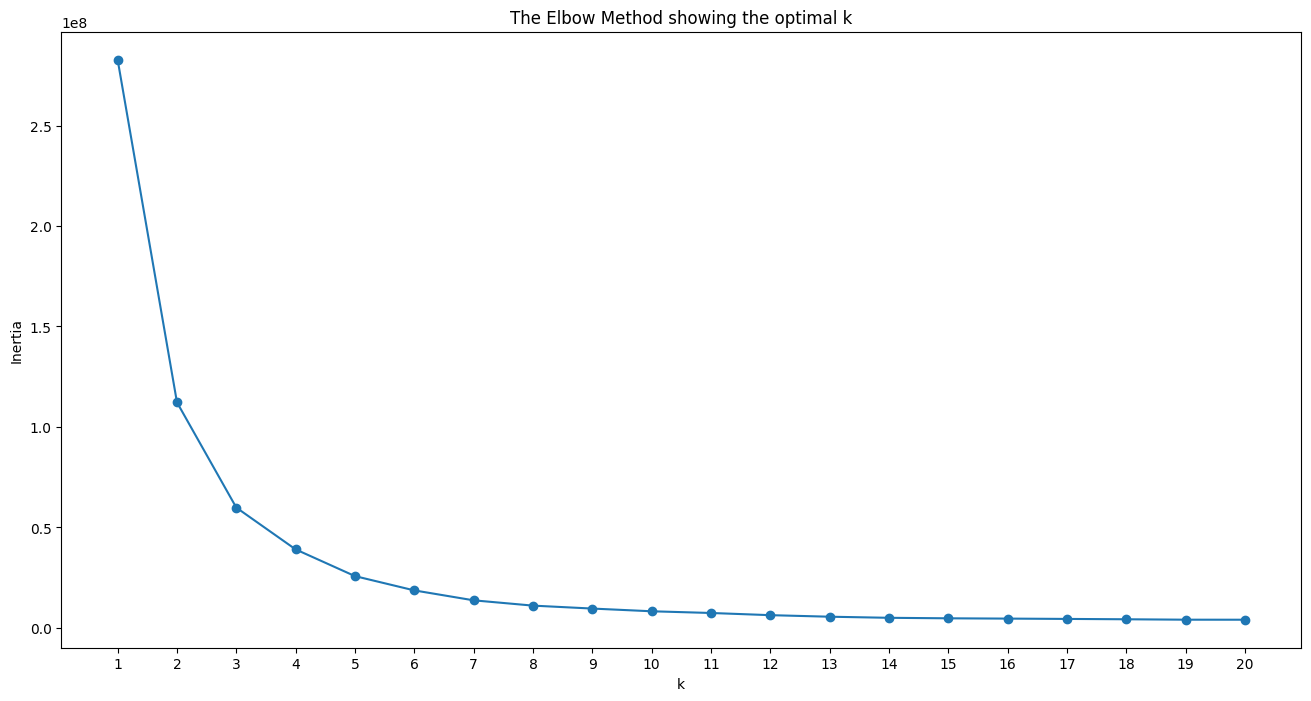

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'o-')
plt.xticks(K)
plt.xlabel('k', )
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the plot of the elbow method above, after ```k=4``` there is a slowing drecrease of inertia, so we can pick that value of ```k```.



In [14]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10, max_iter=100)
kmeans.fit(U)

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=42)

In [15]:
df_kmeans = pd.DataFrame({'movieId': U.index.tolist(), 'cluster': kmeans.labels_})

Since there are some movies that have more than one genre listed, it's important to take all of them, but there are some movies that have no genres listed, and because I'm going to use the ```split()``` function to list all the genres for each cluster, I renamed this label, from ```(no genres listed)``` to ```NoGen```.

In [16]:
df_final = df_kmeans.merge(df_movies, on='movieId', how='inner')[['cluster', 'genres']]
df_final["genres"].loc[df_final["genres"] == '(no genres listed)'] = 'NoGen'

In [17]:
df_clusters = df_final.groupby('cluster')

## 2. Truncated SVD - based embedding plus k-means

In [49]:
r = 20
t0 = time()
svd = TruncatedSVD(r)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)
truncated_U = svd.fit_transform(U)
print("done in %fs" % (time() - t0))

done in 56.240569s


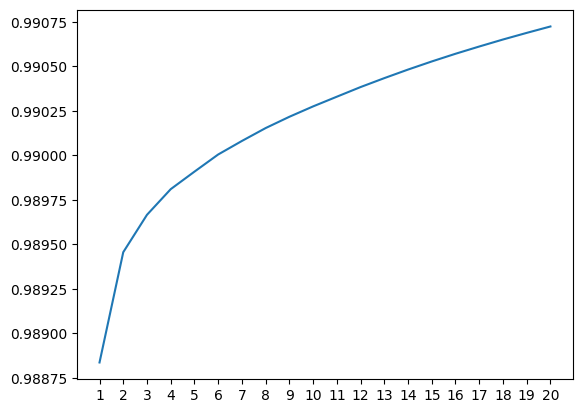

In [51]:
values = list(svd.explained_variance_ratio_)
values.sort(reverse=True)
plt.plot(np.arange(1, r+1, 1), np.cumsum(values), scaley=True)
plt.xticks(np.arange(1, r+1, 1))
plt.show()

In this interval, from $1$ to $20$, there is already an elbow, so we can take ```r=20``` for the ```TruncatedSVD```.

In [52]:
inertias_svd = []
K = np.arange(1, 21, 1).tolist()
for n in tqdm(K):
    kmeans_svd = KMeans(n_clusters=n, init='k-means++', random_state=42, n_init=10, max_iter=100)
    kmeans_svd.fit(truncated_U)
    inertias_svd.append(kmeans_svd.inertia_)

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


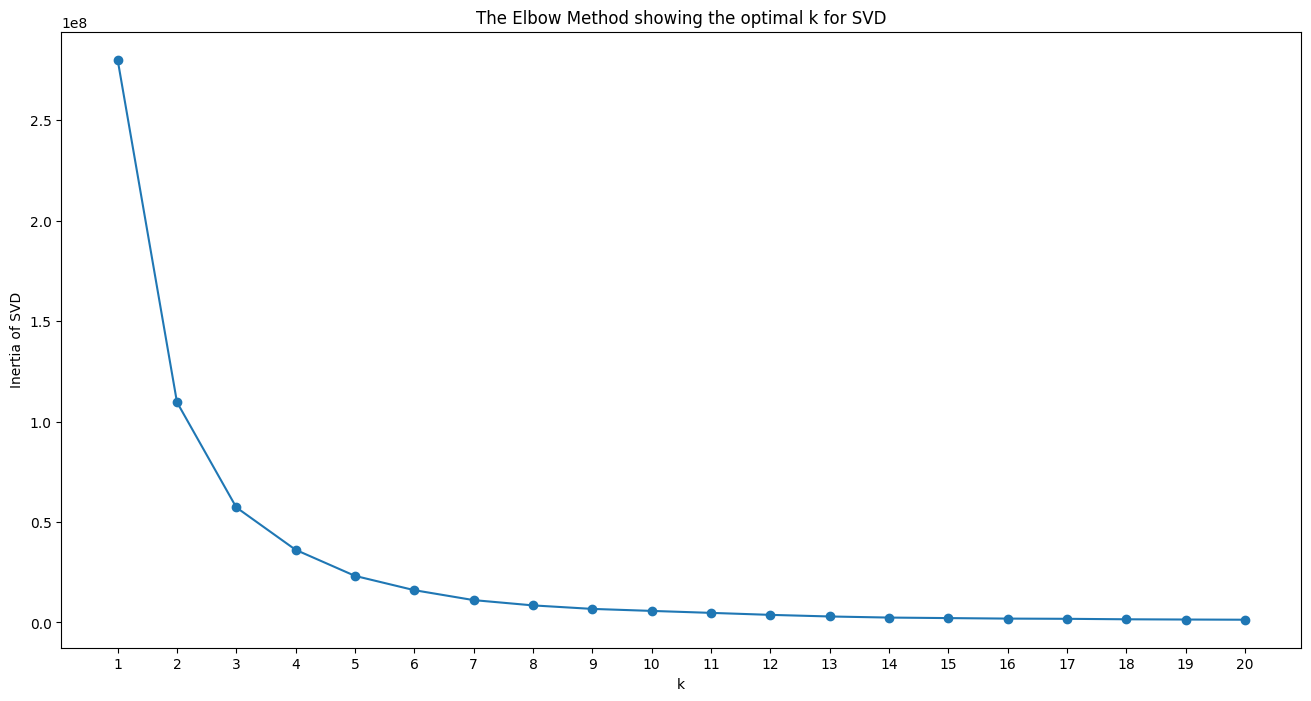

In [55]:
plt.figure(figsize=(16,8))
plt.plot(K, inertias_svd, 'o-')
plt.xticks(K)
plt.xlabel('k', )
plt.ylabel('Inertia of SVD')
plt.title('The Elbow Method showing the optimal k for SVD')
plt.show()

From the plot above, we can still take ```k=4``` for the K-Means, because the plot is very similar to the standard one calculated before.

In [61]:
kmeans_svd = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10, max_iter=100)

kmeans_svd.fit(truncated_U)

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=42)

In [62]:
df_kmeans_svd = pd.DataFrame({'movieId': U.index.tolist(), 'cluster': kmeans_svd.labels_})
df_final_svd = df_kmeans_svd.merge(df_movies, on='movieId', how='inner')[['cluster', 'genres']]
df_final_svd["genres"].loc[df_final_svd["genres"] == '(no genres listed)'] = 'NoGen'

In [63]:
df_clusters_svd = df_final_svd.groupby('cluster')

## Plot the WordClouds

Now it's time to plot for each cluster the WordCloud of the most important genres.

In [76]:
def makeImage(freq_genres, i, title):
    wc = WordCloud(background_color="white")

    # generate word cloud
    wc.generate_from_frequencies(freq_genres)

    # show
    plt.subplot(4, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

In [66]:
def genres_cluster(k, cluster_index, df_grouped):
    if cluster_index > k - 1:
        return
    df_c = df_grouped.get_group(cluster_index)
    genres = " ".join(map(lambda genre: genre.replace('|', " "), df_c.genres)).split()
    count_gens = dict()
    for g in genres:
        count_gens[g] = count_gens.get(g, 0) + 1


    stopwords = ["Comedy", "Drama", "Thriller", "Action", "Adventure"]
    [count_gens.pop(key) for key in stopwords]

    return count_gens

To plot the WordClouds for each cluster, we are going to drop these genres: "Comedy", "Drama", "Thriller", "Action", "Adventure".

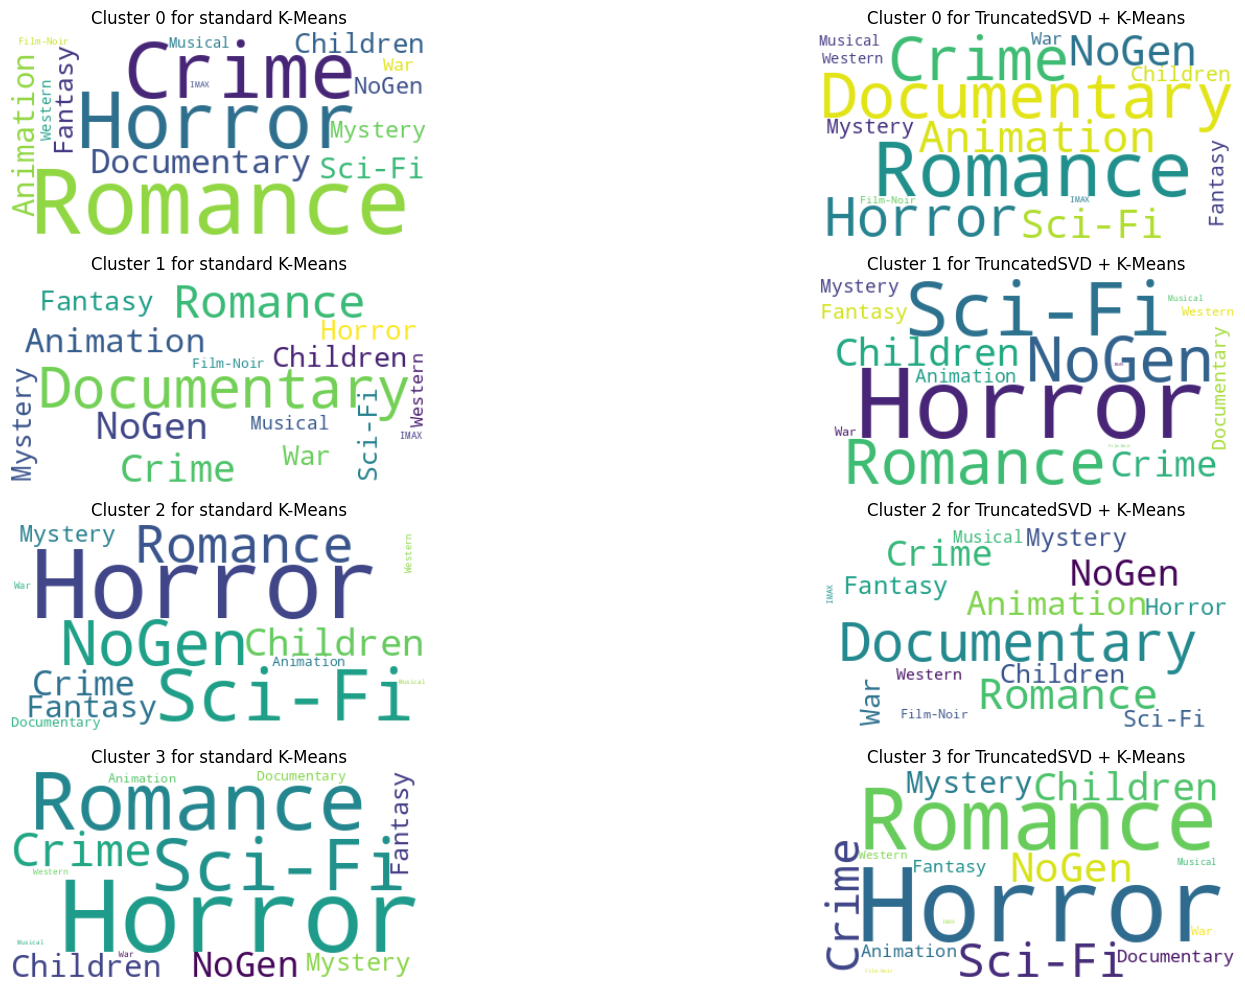

In [78]:
plt.figure(figsize=(20, 10))
box = 1
for i in range(k):
    genres = genres_cluster(k, i, df_clusters)
    genres_svd = genres_cluster(k, i, df_clusters_svd)
    makeImage(genres, box, title=f'Cluster {i} for standard K-Means')
    makeImage(genres_svd, box+1, title=f'Cluster {i} for TruncatedSVD + K-Means')
    box += 2
plt.tight_layout()
plt.show()

From the WordClouds plots, the two methods return basically the same genres frequencies for the clusters, and we can map each cluster in the following way:

1. Cluster 1 standard K-Means with Cluster 2 TruncatedSVD + K-Means;
2. Cluster 2 standard K-Means with Cluster 1 TruncatedSVD + K-Means;
3. Cluster 3 standard K-Means with Cluster 3 TruncatedSVD + K-Means;
4. Cluster 0 standard K-Means with Cluster 0 TruncatedSVD + K-Means.

In 1. the most frequent genres are Documentary, Romance and NoGen. \\
In 2. the most frequent genres are Horror, Sci-Fi and NoGen. \\
In 3. the most frequent genres are Horror, Romance and Sci-Fi. \\
In 4. there is just Romance as the most frequent genre for both clusters, because the others are very diffenrently distributed from each other.

At the end we can say that TruncatedSVD + K-Means is better for clustering, since it's faster than Standard K-Means and doesn't have much difference compared to the latter.